In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')


In [3]:
# Set random seed for reproducibility
np.random.seed(0)

# Generate a date range
date_range = pd.date_range(start='2020-01-01', end='2023-12-31', freq='M')

# Generate sample sales data
sales_data = np.random.poisson(lam=200, size=len(date_range)) + np.linspace(0, 50, len(date_range))

# Create a DataFrame
df = pd.DataFrame(data={'Date': date_range, 'Sales': sales_data})
df.set_index('Date', inplace=True)


In [4]:
df.head(3)

,Sales
Date,
2020-01-31,202.00000
2020-02-29,205.06383
2020-03-31,199.12766


In [5]:
df.describe()

,Sales
count,48.000000
mean,224.166667
std,18.518332
min,181.446809
25%,210.946809
50%,225.319149
75%,240.595745
max,260.744681


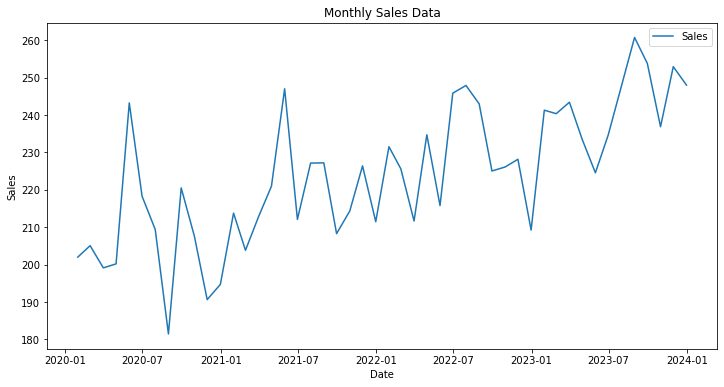

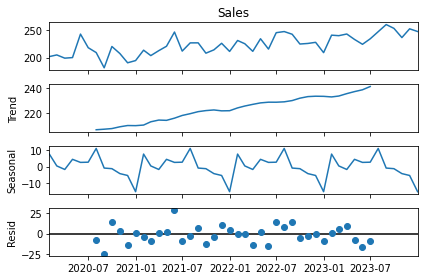

In [6]:
# Plot the sales data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], label='Sales')
plt.title('Monthly Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Decompose the time series
decomposition = seasonal_decompose(df['Sales'], model='additive', period=12)
fig = decomposition.plot()
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')


ADF Statistic: -2.4205453742120953
p-value: 0.13602139215699055
Critical Values: {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}


In [8]:
# Define a function to find the best SARIMA model
def sarima_grid_search(df):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    for p in range(3):
        for d in range(2):
            for q in range(3):
                for P in range(2):
                    for D in range(2):
                        for Q in range(2):
                            try:
                                model = SARIMAX(df['Sales'],
                                                order=(p, d, q),
                                                seasonal_order=(P, D, Q, 12),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                results = model.fit(disp=False)
                                
                                if results.aic < best_aic:
                                    best_aic = results.aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, 12)
                                    best_model = results
                            except:
                                continue

    return best_model, best_order, best_seasonal_order

# Perform grid search
best_model, best_order, best_seasonal_order = sarima_grid_search(df)
print(f'Best SARIMA Order: {best_order}')
print(f'Best Seasonal Order: {best_seasonal_order}')


Best SARIMA Order: (0, 1, 2)
Best Seasonal Order: (0, 1, 1, 12)


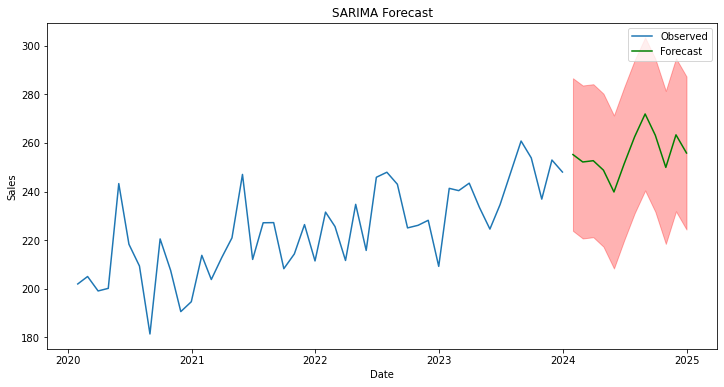

Mean Squared Error: 160.8816737521427


In [9]:
# Forecasting
forecast = best_model.get_forecast(steps=12)
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], label='Observed')
plt.plot(forecast_index, forecast_mean, color='g', label='Forecast')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='r', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate performance metrics
test_data = pd.Series(forecast_mean.values, index=forecast_index)
mse = mean_squared_error(df['Sales'][-12:], test_data)
print(f'Mean Squared Error: {mse}')


In [10]:
# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Forecast': forecast_mean, 
                             'Lower Bound': forecast_conf_int.iloc[:, 0], 
                             'Upper Bound': forecast_conf_int.iloc[:, 1]}, 
                            index=forecast_index)
print(forecast_df)


              Forecast  Lower Bound  Upper Bound
2024-01-31  255.182301   223.817432   286.547169
2024-02-29  252.134771   220.700202   283.569339
2024-03-31  252.661201   221.218659   284.103743
2024-04-30  248.773710   217.331168   280.216253
2024-05-31  239.804385   208.361843   271.246928
2024-06-30  251.329499   219.886957   282.772042
2024-07-31  262.495172   231.052630   293.937715
2024-08-31  271.869192   240.426649   303.311734
2024-09-30  263.120017   231.677474   294.562559
2024-10-31  249.906854   218.464311   281.349396
2024-11-30  263.295768   231.853226   294.738310
2024-12-31  255.825604   224.383061   287.268146
